<a href="https://colab.research.google.com/github/souhirbenamor/EPF/blob/main/EEMD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Time Series Analysis using EMD and Dilated Convolutional Neural Networks¶**
https://github.com/3catz/deeplearning_timeseries/blob/master/Air_Quality_Time_Series_Series_Forecasting_with_EEMD_and_Fully_Convolutional_Neural_Networks.ipynb

In [ ]:
!pip install EMD-signal
!pip install auto_ml
!pip install pyhht
!pip install six
#!pip install -U scikit-learn scipy matplotlib

#import six
#import sys
#sys.modules['sklearn.externals.six'] = six
#from auto_ml import Predictor
#from auto_ml.utils import get_boston_dataset
#from auto_ml.utils_models import load_ml_model

from PyEMD import EEMD 
eemd = EEMD(max_imfs=8)
#pip install PeakUtils
from sklearn.preprocessing import MinMaxScaler, RobustScaler 
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, explained_variance_score

import matplotlib.pyplot as plt
import os 
from scipy.integrate import odeint
#keras
from keras.models import *
from keras.layers import * 
from keras.optimizers import *
from keras.callbacks import *
from keras import backend as K


In [ ]:
def series_to_supervised(data, n_in, n_out, dropnan=True):

	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [ ]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

matplotlib.style.use('ggplot')

In [ ]:
data= pd.read_csv("/content/System load forecast.csv")

In [ ]:
import numpy as np
data = np.genfromtxt("/content/System load forecast.csv", delimiter = ","); data = np.asarray(data); data.shape

(52416,)

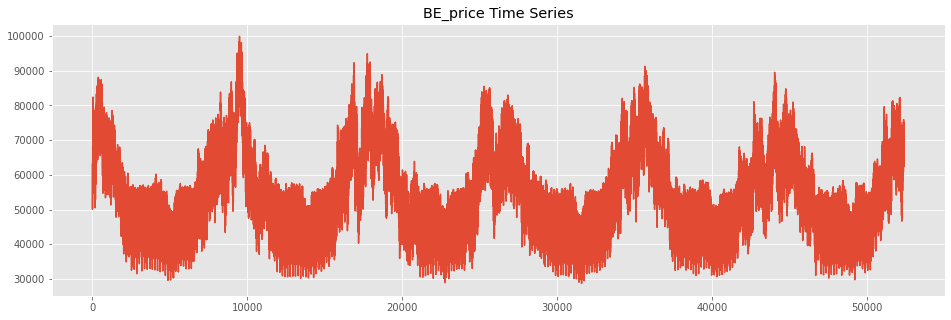

In [ ]:
plt.figure(figsize=(16,5))
plt.plot(data)
plt.title("BE_price Time Series")
plt.show()

# We can scale the data before Decomposition 

In [ ]:
#Scale the Data
scaler = MinMaxScaler(feature_range = (-1,1)) 
scaled_data = scaler.fit_transform(data.reshape(-1,1))
scaled_data.shape
scaled_data = np.squeeze(scaled_data)
scaled_data.shape

(52416,)

In [ ]:
scaled_data = np.transpose(scaled_data)

In [ ]:
# before you do the EMD, cut out the out of sample part so that the EMDs are not constructed with those future values and information contained within them

in_sample = scaled_data[:-17472]; out_sample = scaled_data[-17472:]
print(in_sample.shape)
print(in_sample)

(34944,)
[-0.85461707 -0.86148796 -0.86513911 ... -0.84842763 -0.84868396
 -0.84938418]


# USE NON SCALED DATA in our case since the data will be scaled again with the forecasting model.

In [ ]:
data = np.transpose(data)

In [ ]:
# before you do the EMD, cut out the out of sample part so that the EMDs are not constructed with those future values and information contained within them

in_sample = data[:-17472]; out_sample = data[-17472:]
print(in_sample.shape)
print(in_sample)

(34944,)
[63000. 58800. 58500. ... 64515. 62554. 67342.]


In [ ]:
in_sample = in_sample.reshape(-1,1)
out_sample = out_sample.reshape(-1,1)
print(in_sample)


[[63000.]
 [58800.]
 [58500.]
 ...
 [64515.]
 [62554.]
 [67342.]]


In [ ]:
#eemd for in-sample
eemd = EEMD()
eemd.extrema_detection = "simple"
t = np.linspace(0, in_sample.shape[0], in_sample.shape[0])
t = t.reshape(-1,1)
print(t.shape, in_sample.shape)
t = np.squeeze(t)
in_sample = np.squeeze(in_sample)




(34944, 1) (34944, 1)


In [ ]:
#eemd for in-sample
imfs_in = eemd(in_sample, t, 8)

print(imfs_in.shape)

(9, 34944)


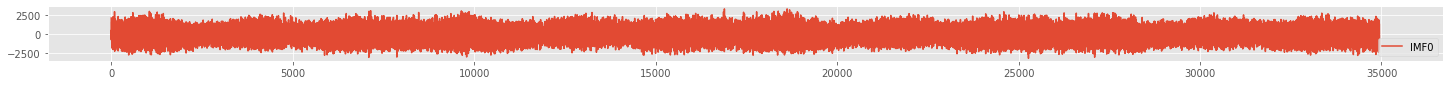

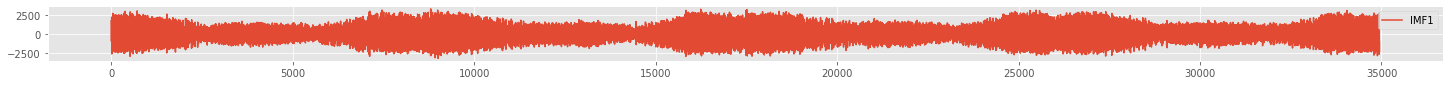

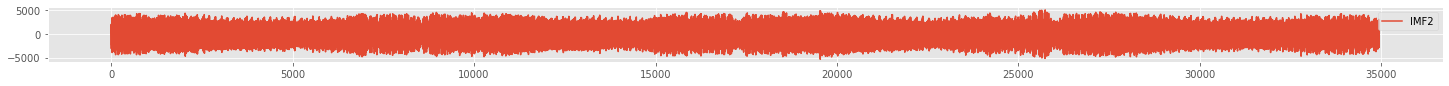

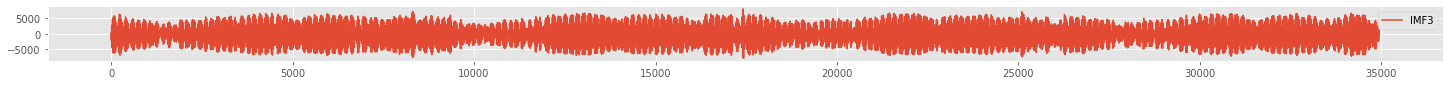

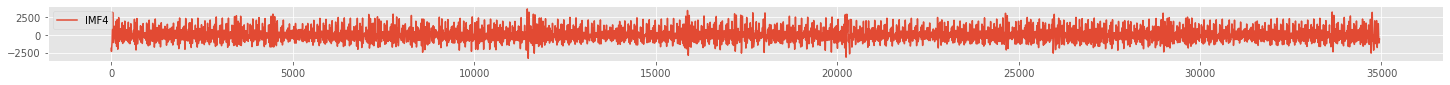

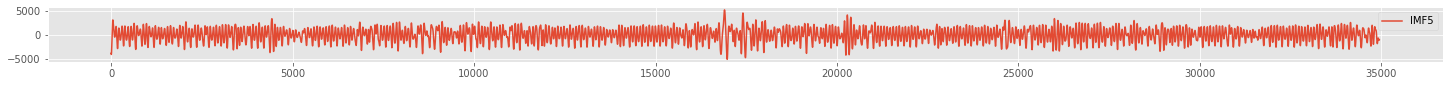

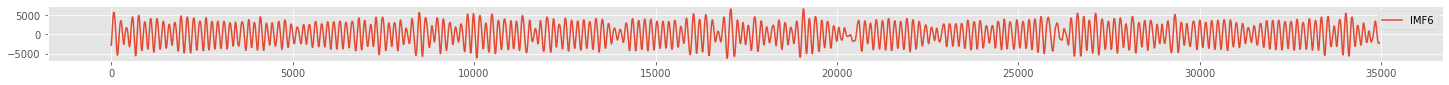

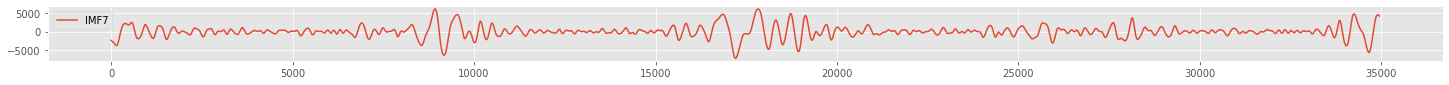

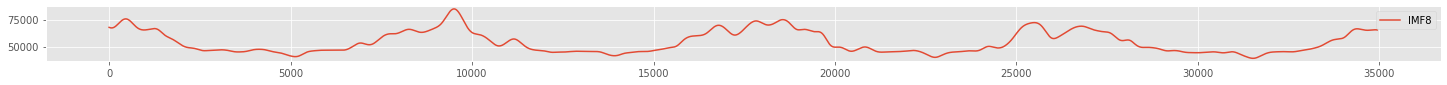

In [ ]:
for i in range(len(imfs_in)):
  fig, ax = plt.subplots(figsize=(25,1))
  fig = plt.plot(imfs_in[i], label = "IMF{}".format(i))
  plt.legend()
  plt.show()

In [ ]:
#eemd for out-sample
eemd = EEMD()
eemd.extrema_detection = "simple"
t_out = np.linspace(0, out_sample.shape[0], out_sample.shape[0])
t_out = t_out.reshape(-1,1)
print(t_out.shape, out_sample.shape)
t_out = np.squeeze(t_out)
out_sample = np.squeeze(out_sample)


(17472, 1) (17472, 1)


In [ ]:
#eemd for out-sample
imfs_out = eemd(out_sample, t_out, 8)

print(imfs_out.shape)

(9, 17472)


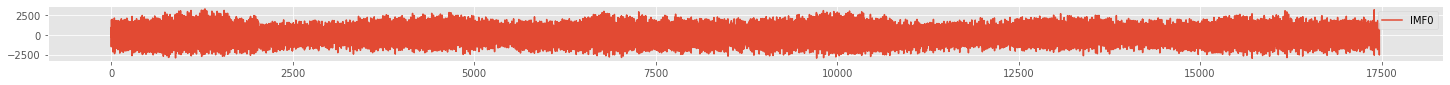

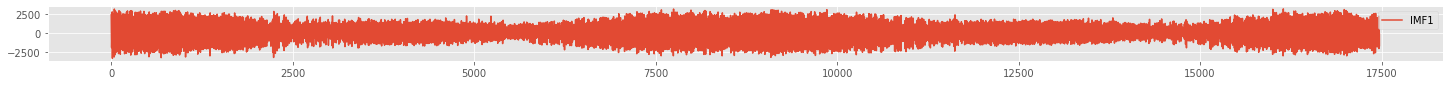

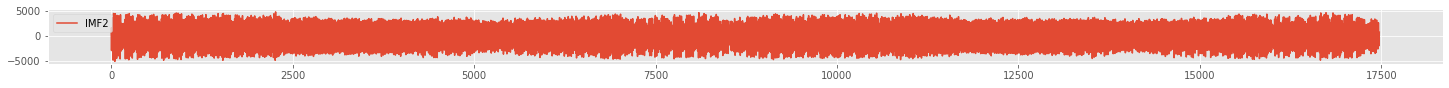

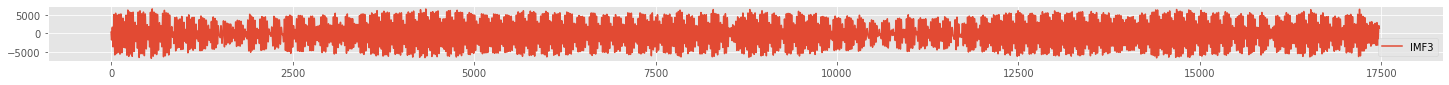

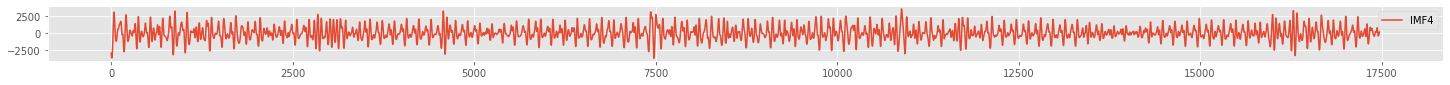

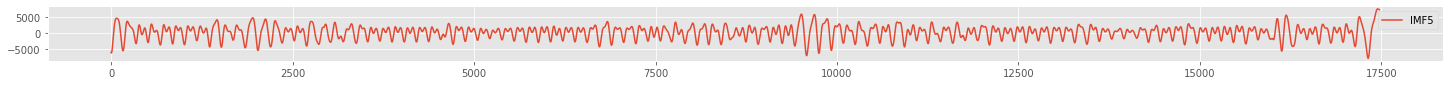

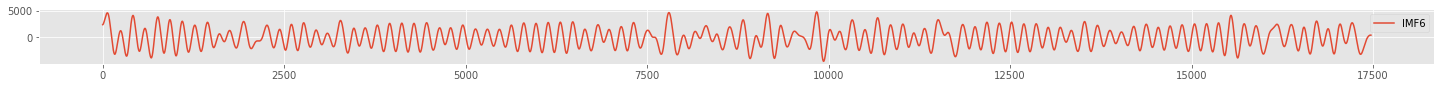

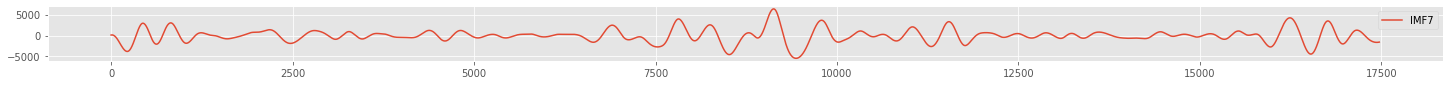

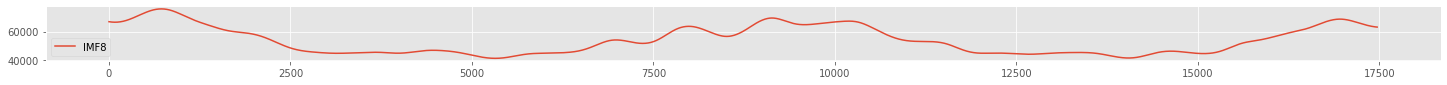

In [ ]:
for i in range(len(imfs_out)):
  fig, ax = plt.subplots(figsize=(25,1))
  fig = plt.plot(imfs_out[i], label = "IMF{}".format(i))
  plt.legend()
  plt.show()

In [ ]:
# Save in_sample and out_sample decomposition data
from pandas import DataFrame
import pandas as pd
import csv
Eemd_in_sample=pd.DataFrame(imfs_in).T
Eemd_out_sample=pd.DataFrame(imfs_out).T
#Unscaled decomposed data
#Eemd_in_sample_unscaled=scaler.inverse_transform(Eemd_in_sample['0'])
#Eemd_out_sample_unscaled=scaler.inverse_transform(Eemd_out_sample.reshape(-1,1))
# Save as csv
Eemd_in_sample.to_csv("Eemd_in_sample.csv", header=True, quoting=csv.QUOTE_NONE, escapechar=' ')
Eemd_out_sample.to_csv("Eemd_out_sample.csv", header=True, quoting=csv.QUOTE_NONE, escapechar=' ')

# Save as excel
Eemd_in_sample.to_excel("Eemd_in_sample.xlsx", header=True)
Eemd_out_sample.to_excel("Eemd_out_sample.xlsx", header=True)
print(Eemd_in_sample)
print(Eemd_out_sample)


                 0            1            2            3            4  \
0      2119.366482  1709.557011  1985.355556   158.475258 -1887.391150   
1      -735.038542  1062.295519  1772.444147  -249.354636 -2038.633533   
2       885.755429   360.728268   830.912726  -726.424432 -2159.087954   
3      -463.512464  -379.525720  -497.740803 -1221.980721 -2247.695599   
4       -11.928462  -943.481930 -1818.987896 -1664.308849 -2304.648534   
...            ...          ...          ...          ...          ...   
34939   853.158482  2719.338978  -686.802498   115.378483  -687.074933   
34940     2.130342   911.640675   112.709043    46.601739  -649.867846   
34941  -245.827202 -1598.821832   581.010205    35.992982  -623.795490   
34942 -1709.870825 -2360.054683   809.828906    35.728427  -607.081364   
34943  1271.169791 -1053.569522   967.304843    11.581182  -597.459232   

                 5            6            7             8  
0     -3722.723507 -2822.837132 -2374.489006  6781

In [ ]:
Eemd_in_sample

,0,1,2,3,4,5,6,7,8
0,2119.366482,1709.557011,1985.355556,158.475258,-1887.391150,-3722.723507,-2822.837132,-2374.489006,67815.814425
1,-735.038542,1062.295519,1772.444147,-249.354636,-2038.633533,-3804.614654,-2788.006043,-2382.244465,67801.395056
2,885.755429,360.728268,830.912726,-726.424432,-2159.087954,-3869.891518,-2745.560561,-2389.946493,67787.148929
3,-463.512464,-379.525720,-497.740803,-1221.980721,-2247.695599,-3917.689780,-2695.387270,-2397.596103,67773.077193
4,-11.928462,-943.481930,-1818.987896,-1664.308849,-2304.648534,-3947.237378,-2637.439523,-2405.193869,67759.181012
...,...,...,...,...,...,...,...,...,...
34939,853.158482,2719.338978,-686.802498,115.378483,-687.074933,-1000.698119,-2216.170782,4315.452911,65436.823689
34940,2.130342,911.640675,112.709043,46.601739,-649.867846,-994.154824,-2196.634728,4302.361991,65432.926912
34941,-245.827202,-1598.821832,581.010205,35.992982,-623.795490,-985.319710,-2175.751323,4289.008348,65428.981808
34942,-1709.870825,-2360.054683,809.828906,35.728427,-607.081364,-974.331993,-2153.512169,4275.390216,65424.988764


In [ ]:

# Merge in_ and out_samples in one file and save the full decomposed sample  

frames = [Eemd_in_sample, Eemd_out_sample]

BE_price_Eemd = pd.concat(frames)
BE_price_Eemd=BE_price_Eemd.reset_index()
del BE_price_Eemd[BE_price_Eemd.columns[0]]
BE_price_Eemd.to_csv("BE_price_Eemd.csv", header=True, quoting=csv.QUOTE_NONE, escapechar=' ')
BE_price_Eemd.to_excel("BE_price_Eemd.xlsx", header=True)
print(BE_price_Eemd)

                 0            1            2            3            4  \
0      2119.366482  1709.557011  1985.355556   158.475258 -1887.391150   
1      -735.038542  1062.295519  1772.444147  -249.354636 -2038.633533   
2       885.755429   360.728268   830.912726  -726.424432 -2159.087954   
3      -463.512464  -379.525720  -497.740803 -1221.980721 -2247.695599   
4       -11.928462  -943.481930 -1818.987896 -1664.308849 -2304.648534   
...            ...          ...          ...          ...          ...   
52411  1429.824664  2232.014997  -964.601852  1918.954737    32.602860   
52412   296.942837   688.443335  -340.541308  1799.875770    72.458365   
52413  -595.294844 -1399.829833   165.707962  1671.326204   106.511747   
52414 -2543.957909 -1766.585416   517.548743  1542.402491   135.172691   
52415  1269.849517  -147.697556   729.091921  1416.527188   159.376061   

                 5            6            7             8  
0     -3722.723507 -2822.837132 -2374.489006  6781